In [1]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

c:\Users\Pedro Antônio Silva\Desktop\Semestre 4\Machine Learning\proj_1\ames\data


In [4]:
def nonNull_percent(label, null_value = 0 ):
    f = data[label] != null_value
    return (data[label][f].value_counts().sum()/data[label].shape[0] *100)

In [5]:
def heatMapCorr(labels):
    correlation_matrix = data[labels + ["SalePrice"]].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

array([[<AxesSubplot:title={'center':'Lot.Frontage'}>,
        <AxesSubplot:title={'center':'Lot.Area'}>,
        <AxesSubplot:title={'center':'Lot.Shape'}>,
        <AxesSubplot:title={'center':'Land.Slope'}>,
        <AxesSubplot:title={'center':'Overall.Qual'}>,
        <AxesSubplot:title={'center':'Overall.Cond'}>,
        <AxesSubplot:title={'center':'Mas.Vnr.Area'}>,
        <AxesSubplot:title={'center':'Exter.Qual'}>,
        <AxesSubplot:title={'center':'Exter.Cond'}>,
        <AxesSubplot:title={'center':'BsmtFin.SF.1'}>,
        <AxesSubplot:title={'center':'BsmtFin.SF.2'}>,
        <AxesSubplot:title={'center':'Bsmt.Unf.SF'}>,
        <AxesSubplot:title={'center':'Total.Bsmt.SF'}>],
       [<AxesSubplot:title={'center':'Heating.QC'}>,
        <AxesSubplot:title={'center':'Electrical'}>,
        <AxesSubplot:title={'center':'X1st.Flr.SF'}>,
        <AxesSubplot:title={'center':'X2nd.Flr.SF'}>,
        <AxesSubplot:title={'center':'Low.Qual.Fin.SF'}>,
        <AxesSubplot:titl

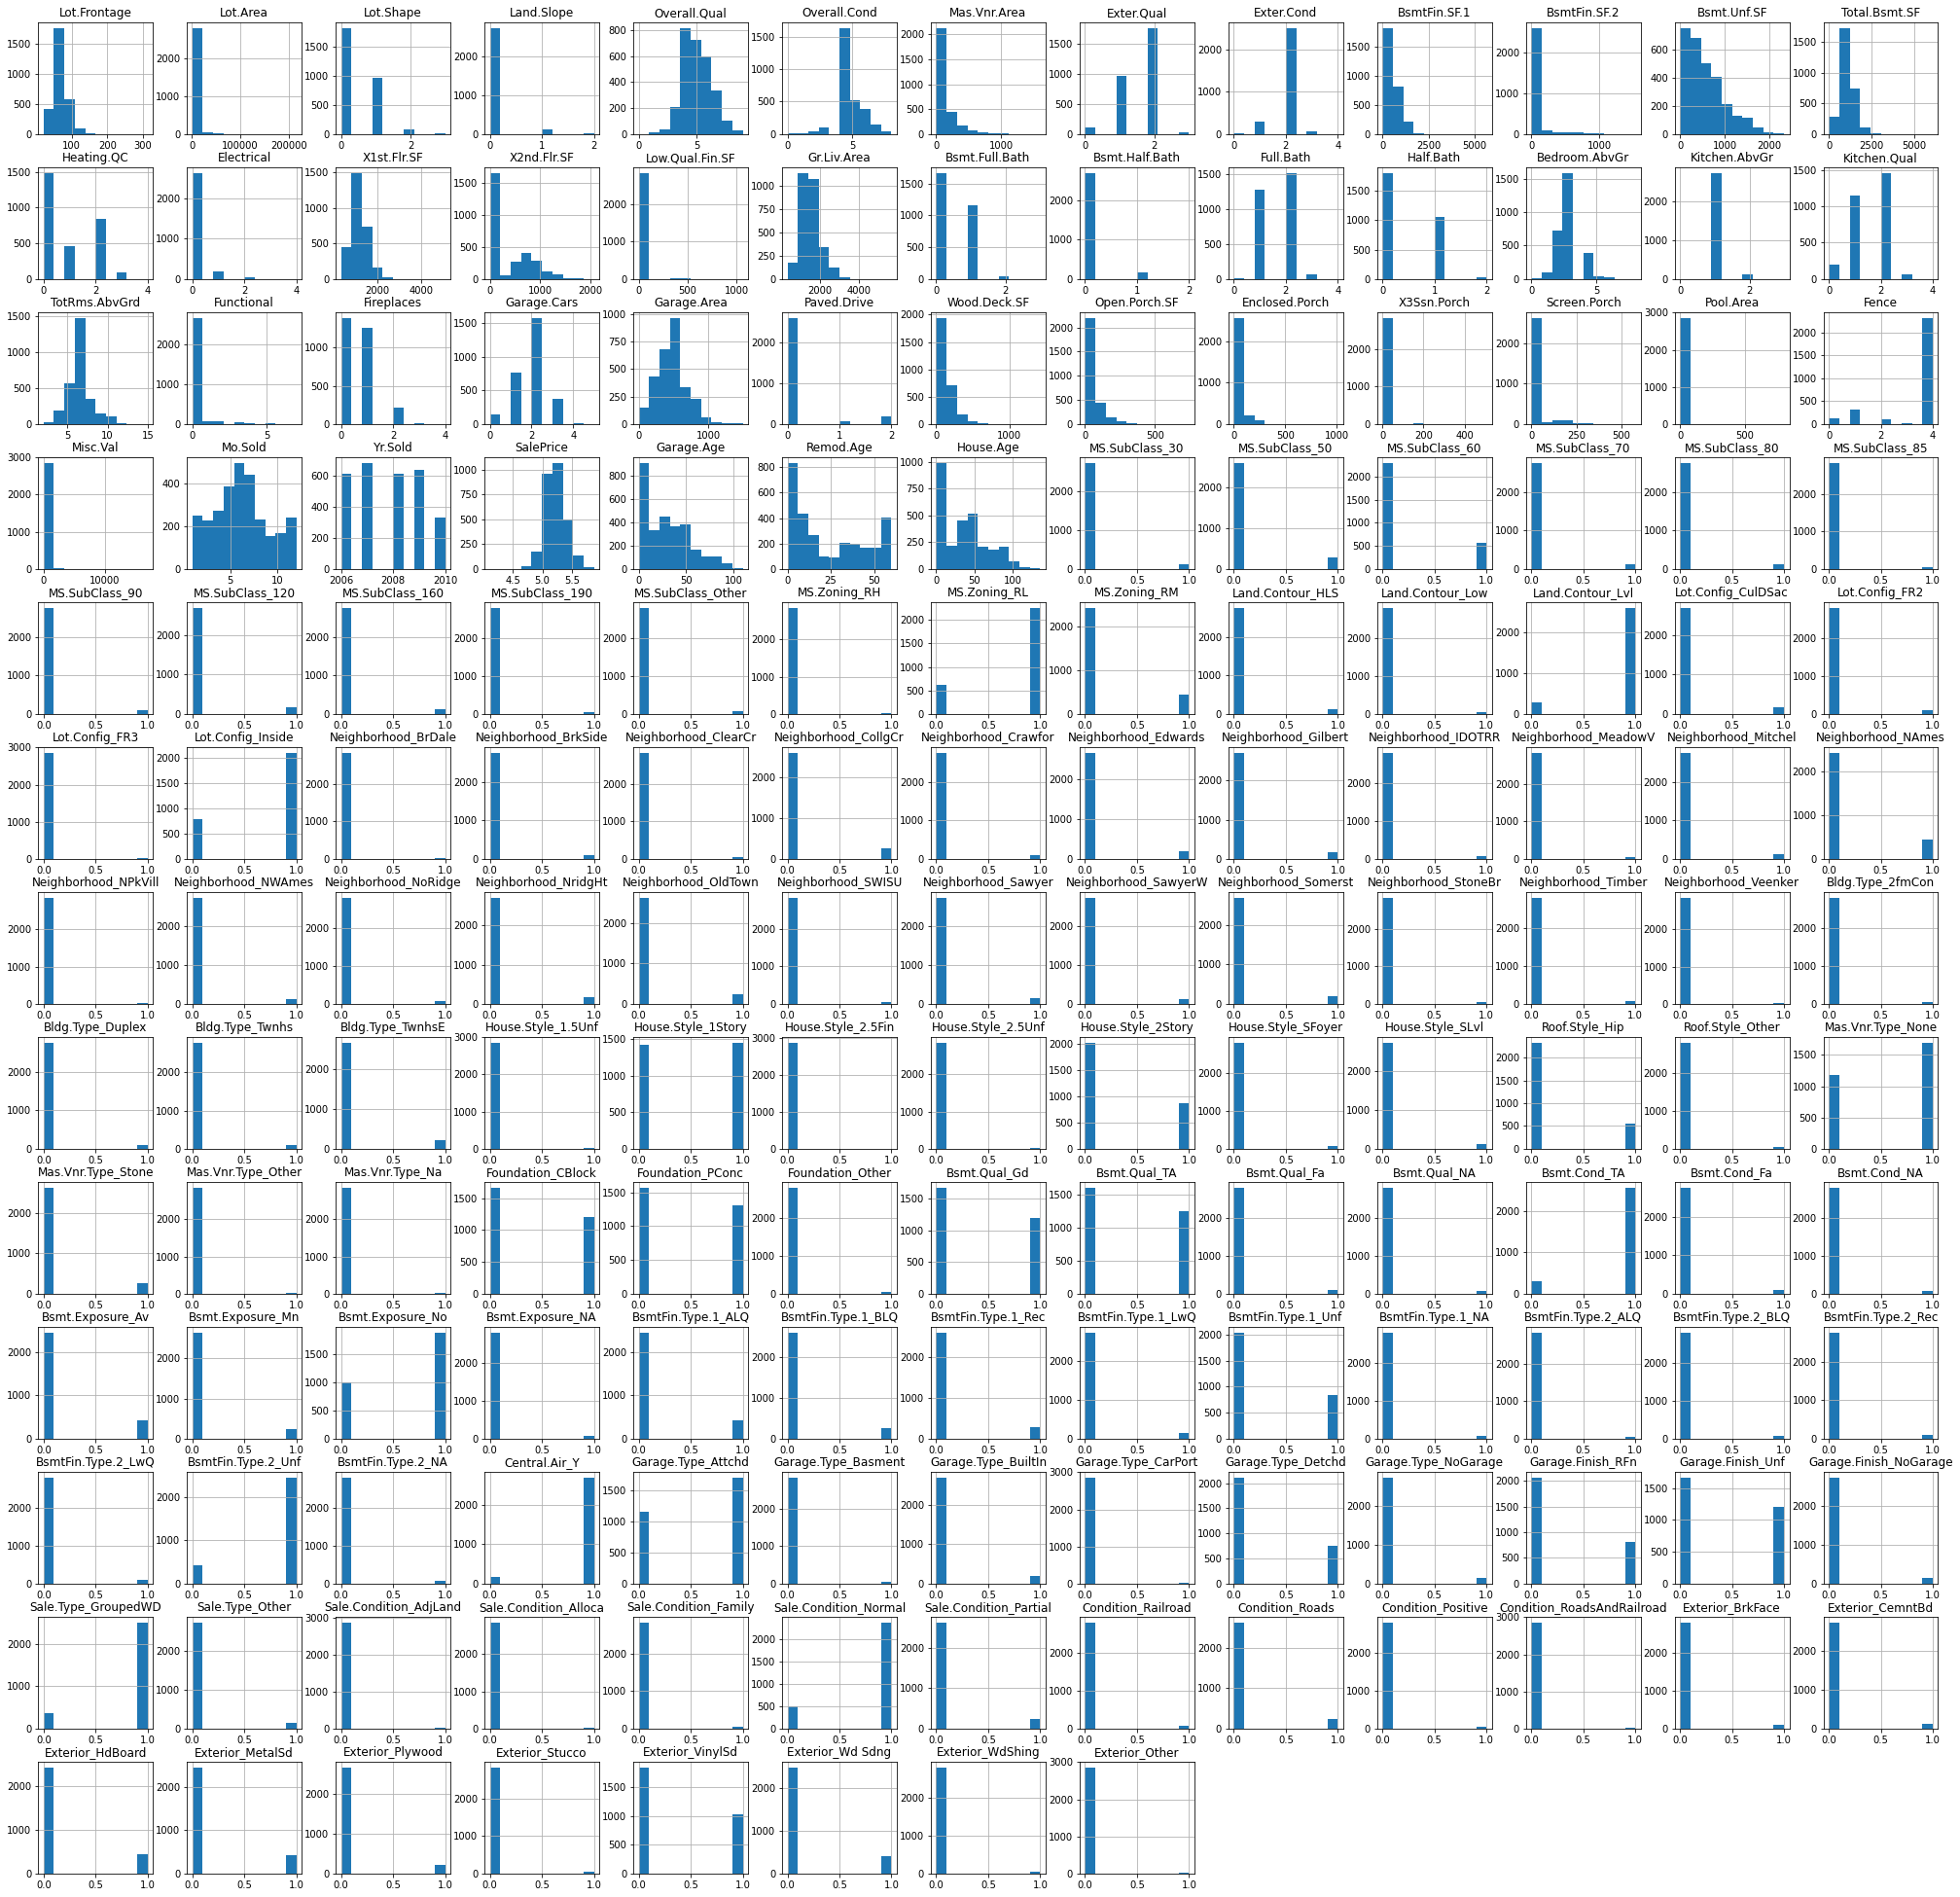

In [7]:
data.hist(figsize=(35,35))

In [8]:
## We could drop those...
dropList = []
# pool area - pool area =D
nonNull_percent("Pool.Area")
dropList.append("Pool.Area") # questionable but...

# X3Ssn.Porch - Three season porch area in square feet  }
# Screen.Porch - Screen porch area in square feet       } Results don't make sense, so leave it there...
# *Enclosed.Porch - Enclosed porch area in square feet  }

# Misc.Val - $Value of miscellaneous feature
nonNull_percent("Misc.Val")
dropList.append("Misc.Val")

# BsmtFin.SF.2 - Rating of basement finished area (if multiple types) - We'll see this later on the analysis.

# Lot.Area - Lot size in square feet - NOT REMOVE

# Kitchen.AbvGr
nonNull_percent("Kitchen.AbvGr", 1)
# dropList.append("Kitchen.AbvGr")
# Bsmt.Half.Bath
nonNull_percent("Bsmt.Half.Bath")
dropList.append("Bsmt.Half.Bath")
# Low.Qual.Fin.SF
nonNull_percent("Low.Qual.Fin.SF")
dropList.append("Low.Qual.Fin.SF")

# # Land.Slope - 
# nonNull_percent("Land.Slope")
# dropList.append("Land.Slope")     Didn't change or fucked up
# # Functional - 
# nonNull_percent("Functional")
# dropList.append("Functional")

# Mas.Vnr.Area -

# Electrical
nonNull_percent("Electrical")
# dropList.append("Electrical")

# Central.Air
nonNull_percent("Central.Air_Y")
# dropList.append("Central.Air_Y")



93.81299965241571

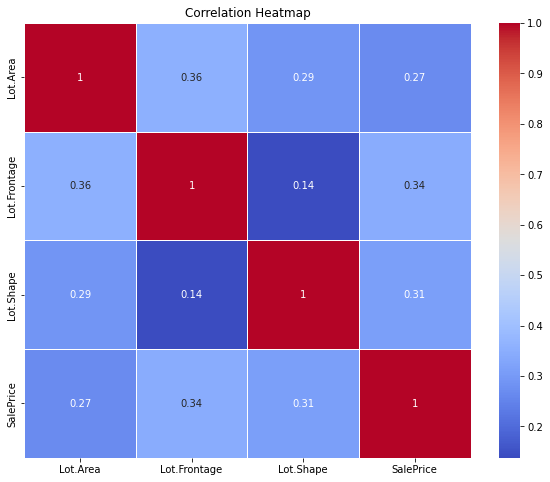

In [10]:
lot_cat = ["Lot.Area","Lot.Frontage","Lot.Shape"]
heatMapCorr(lot_cat)

6.18700034758429

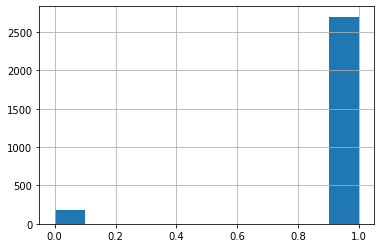

In [ ]:
# testing / visualization cell
analyse = "Central.Air_Y"
data[analyse].hist()
nonNull_percent(analyse,1)

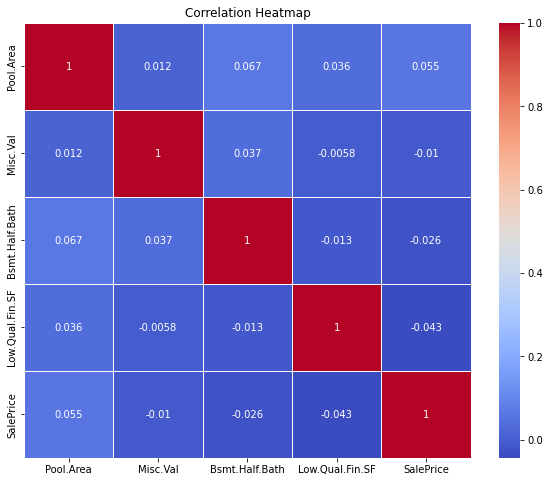

In [ ]:
heatMapCorr(dropList)
data = data.drop(columns=dropList)

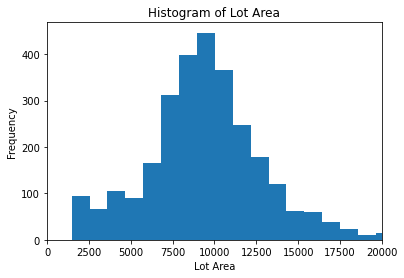

In [ ]:
plt.hist(data["Lot.Area"], bins=200 )  # You can adjust the number of bins as needed
plt.xlabel("Lot Area")
plt.ylabel("Frequency")
plt.title("Histogram of Lot Area")
plt.xlim(0, 20000)
plt.show()

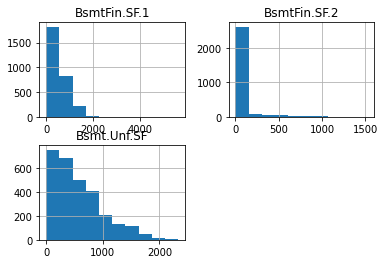

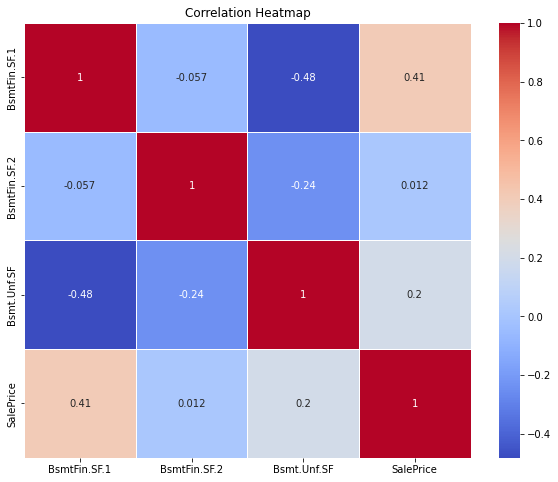

In [ ]:
basement_cat = ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF"]
for col  in basement_cat:
    nonNull_percent(col)

data[basement_cat].hist()
heatMapCorr(basement_cat)

In [ ]:
data = data.drop(columns=["BsmtFin.SF.2","Total.Bsmt.SF"])

In [ ]:
porch_cat = ["Enclosed.Porch", "Screen.Porch", "X3Ssn.Porch"]
# data["Total.Porch.Area"] = data["Enclosed.Porch"] + data["Screen.Porch"] + data["X3Ssn.Porch"]

for cat in porch_cat:
    print(nonNull_percent(cat))

# print(nonNull_percent("Total.Porch.Area"))
# heatMapCorr(porch_cat+["Total.Porch.Area"])

# data = data.drop(columns=porch_cat)

15.363225582203684
8.86339937434828
1.251303441084463
